In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import math
import random

if torch.cuda.is_available():
  dev = 'cuda'
  print("Cuda avaiable. Device used to train the model:", dev)
else: 
  dev = 'cpu'
  print("Cuda not avaiable. Device used to train the model:", dev)


Cuda avaiable. Device used to train the model: cuda


/disks/disk1/giudiciga/miniconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **A harmonic series dataset**

This dataset generates an input signal and an output signal, given a harmonic distribution and a number of cycles we want to compute.

In [2]:
# Multishape dataset
class HarmonicSeriesDataset(Dataset):
    """ Class to generate an harmonic series dataset (input+output).
    Args:
    harmonics = harmonic distribution of output signal
    shape = 'step' or 'ramp'
    amplitudes = set of max amplitudes of the signals of the dataset
    n_periods = number of periods to compute
    """
    
    def __init__(self, harmonics, shape='step', amplitudes=[0.25, 0.5, 0.75, 1.0], n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.shape = shape if shape in ['step', 'ramp'] else 'step'
        self.len = n_periods*2*harmonics.size()[0]
        self.amplitudes = amplitudes
        self.sample_rate = 2*harmonics.size()[0]
        self.sample_time = 1/(2*harmonics.size()[0])
        self.n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(self.n_freqs)
        self.freqs = torch.linspace(start=0, end=self.n_freqs-1, steps=self.n_freqs)
    
    def __len__(self):
        return 128

    def __getitem__(self, idx):
      
      self.phases[:] = 0
      amp = np.random.choice(self.amplitudes)
      d_1 = np.random.randint(0,self.len/2)
      d_2 = np.random.randint(self.len/2,self.len-2)
      check = np.random.choice([True,False])
      on_off = torch.ones(self.len) if(check) else torch.zeros(self.len)
      on_off[d_1:d_2] = 0 if(check) else 1
      
      # Define Input
      #if self.shape == 'random':
      #  input = torch.rand(self.len)*amp if(check) else torch.zeros(self.len)
      #  input[d_1:d_2] = 0 if(check) else torch.rand(d_2-d_1)*amp
      #else:
      #  input = torch.ones(self.len)*amp if(check) else torch.zeros(self.len)
      #  input[d_1:d_2] = 0 if(check) else amp
      
      input = torch.ones(self.len)*amp if(check) else torch.zeros(self.len)
      input[d_1:d_2] = 0 if(check) else amp
      # Define Outpu
      output = torch.zeros(self.len)
        
      for i in range(self.len): 
        
        if self.shape == 'ramp':
          if i == 0:
            input[i] = self.sample_time if on_off[i] else 0
          else:
            input[i] = input[i-1] + self.sample_time if on_off[i] else 0
          
        # Clip input from 0 to amp
        input[i] = input[i].clip(0,amp)  
        
        self.phases += (2*np.pi*self.freqs/self.sample_rate)
        self.phases = self.phases * on_off[i]
        output[i] = torch.sum(self.harmonics*torch.sin(self.phases))*input[i]    
      
      return input, output

# Dataset
Let's generate a dataset and plot its content.

/tmp/ipykernel_6086/380904300.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.harmonics = torch.tensor(harmonics)


240
2
Samples.shape: torch.Size([64, 240, 2])


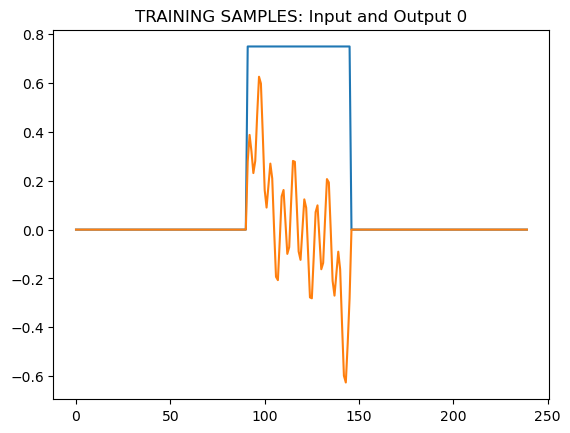

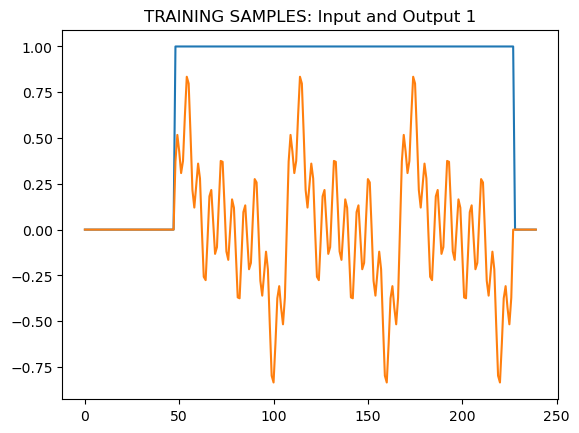

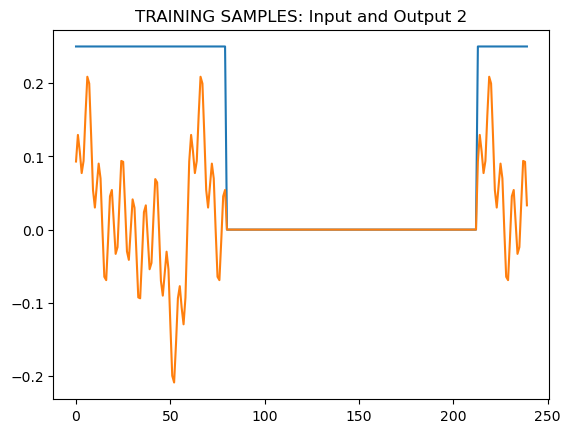

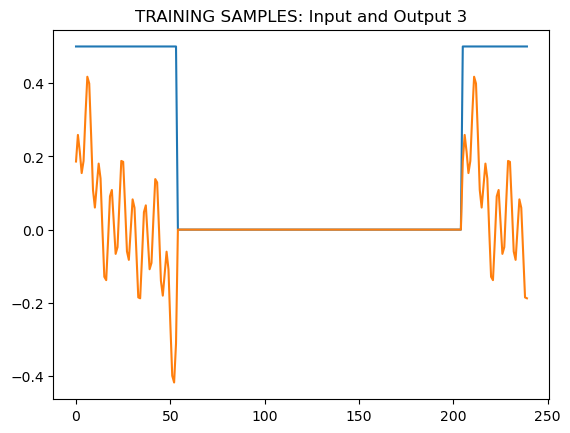

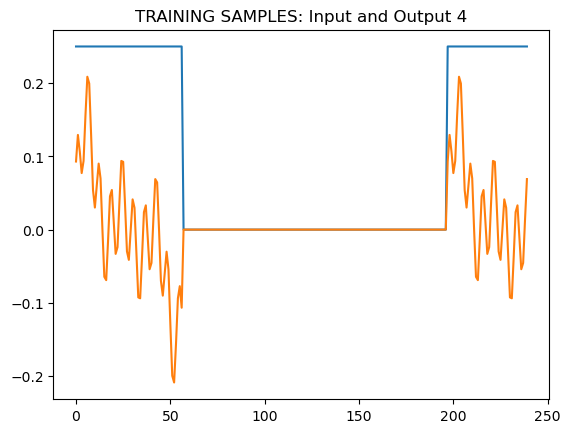

In [4]:
# Dataset configuration
period_len = 60
n_periods = 4
# Generate a distribution of harmonics
harmonics = torch.zeros(period_len//2)
harmonics[1] = 1
harmonics[2] = 1
harmonics[3] = 1
harmonics[10] = 1
# Normalize distribution
harmonics = harmonics/torch.sum(harmonics)

# Create dataset
batch_size = 64
amplitudes = np.linspace(0,1,5)
train_dataset = HarmonicSeriesDataset(harmonics=harmonics, shape='step', amplitudes=amplitudes, n_periods=n_periods)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

# Sample storage to plot
signal_len = len(train_dataloader)
print(period_len*n_periods)
print(signal_len)

# Examples of dataset
train_samples = torch.zeros(batch_size,period_len*n_periods,2)

train_samples[:,:,0], train_samples[:,:,1] = next(iter(train_dataloader))

print("Samples.shape:", train_samples.shape)
for i in range(5):
  plt.plot(train_samples[i,:,0].detach().cpu().numpy())
  plt.plot(train_samples[i,:,1].detach().cpu().numpy())
  plt.title("TRAINING SAMPLES: Input and Output {}".format(i))
  plt.show()



# **Gated Recurrent Unit (GRU)**

In [6]:
class GRUmodel(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, num_layers=1):
    super(GRUmodel, self).__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    # GRU (input)
    self.gru = nn.GRU(input_size, hidden_dim, num_layers=num_layers, batch_first=True)
    # Fully connected (output)
    self.lin = nn.Linear(hidden_dim, output_size)
    
  # Forward method
  def forward(self, seq):

    input = seq  # input.shape = (batch_size, sequence_length ,input_size)
  
    out, hidden = self.gru(input) # out.shape = (sequence_length, hidden_dim) # hidden.shape = (num_layers, hidden_dim)
    out = self.lin(out) # out.shape = (sequence_length,1)
    return out


In [ ]:
def gru_evaluate_on_data(net, eval_input, target, device, plot=False):

  L = target.shape[1] # sequence length
  batch_size = target.shape[0] # batch size
  random = np.random.randint(0,batch_size-2)
  target = target[random,:,:].unsqueeze(0).to(device) # ([N,L,1])
  # seq = torch.ones([batch_size,L,1]).to(device) # ([N,L,1])
  seq = eval_input[random,:,:].unsqueeze(0).to(device)

  with torch.no_grad():
    pred = net(seq)
      # Calculate evaluation loss
  eval_loss = torch.sum(torch.abs(target-pred))

  # Plotting results
  if(plot):
    fig, ax = plt.subplots()
    print("[TEST ON DATA] Eval loss {}".format(eval_loss))
    ax.plot(seq[0,:,:].detach().cpu().numpy())
    ax.plot(target[0,:,:].detach().cpu().numpy())
    ax.plot(pred[0,:,:].detach().cpu().numpy())
    plt.show()

  return eval_loss
  
def gru_train(net, epochs, train_dataloader, device, save_state='best_gru.pt'):
  
  net.train()

  # Define Loss, Optimizer, ecc.
  criterion = nn.L1Loss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  best_eval_loss = np.inf

  # target = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1])
  # train = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1]) 
  # L = target.shape[1] # sequence length
  # n_batches = target.shape[0] # batch size
  epochs_loss = np.zeros(epochs)

  for epoch in range(epochs): 
    optimizer.zero_grad()
    running_loss = 0.0

    for i,sample in enumerate(train_dataloader):
      seq,target = sample
      target = target.unsqueeze(2).to(device)
      seq = seq.unsqueeze(2).to(device)
      prediction = net(seq)
      loss = criterion(prediction, target) # Calculate loss
      loss.backward() # Backpropagation and calculates gradients
      optimizer.step() # Updates the weights
    # Print statistics
    running_loss += loss.item() # To calculate epochs' mean loss
    plot = True if (epoch%(epochs/16)==0) else False
    eval_loss = gru_evaluate_on_data(net, seq, target, device, plot=plot)
    
    epochs_loss[epoch] = eval_loss # For plotting loss during epochs

    if eval_loss < best_eval_loss:
      best_eval_loss = eval_loss
      torch.save(net.state_dict(), save_state)

    if (epoch%(epochs/20) == 0):
        print('Epoch: {}/{} .............'.format(epoch, epochs), end=' ')
        print("Train Loss: {:.4f} - Best Eval {:.4f}".format(running_loss, best_eval_loss))
    
    running_loss = 0.0

  print("---------- FINISHED TRAINING ----------")

  # Print Eval Loss
  x_ = np.linspace(0, epochs-1, epochs)
  y_ = epochs_loss
  yhat_ = signal.savgol_filter(y_, 101, 3) # Savitzky-Golay filter for smoothing

  fig, ax = plt.subplots()
  ax.plot(x_, y_)
  ax.plot(x_, yhat_)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Eval Loss') 
  # ax.grid(True) 
  plt.show()

# **Training GRUnet**

In [5]:
def train_and_test_GRU(hidden_size, n_hidden_layers, train_dataloader, target, epochs, device, save_state='best_gru.pt'):
  #train_len = train_data.size()[2]

  net = GRUmodel(1,1,hidden_size, n_hidden_layers)
  net = net.to(device)

  model_parameters = filter(lambda p: p.requires_grad, net.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("[INFO] Number of parameters: {}".format(params))
  
  # TRAINING
  gru_train(net, epochs, train_dataloader, device, save_state)

  # TEST
  net.load_state_dict(torch.load(save_state))  
  net.eval()
  input,target = next(iter(train_dataloader))
  input = input.unsqueeze(2)
  target = target.unsqueeze(2)
  gru_evaluate_on_data(net, input, target, device, plot=True)

  return net

In [ ]:
GRUnet = train_and_test_GRU(hidden_size=64, n_hidden_layers=1, train_dataloader=train_dataloader, target=train_dataloader, epochs=5000, device=dev, save_state='./nn_saved_states/multi_1602_001.pt')

# **Testing Trained GRUnet**

## Load Pre-trained Net for Testing [Optional]

In [14]:
GRUnet = GRUmodel(1,1,64,1)
GRUnet = GRUnet.to(dev)
GRUnet.load_state_dict(torch.load('./nn_saved_states/multi_1402_001.pt'))

<All keys matched successfully>

## Testing with step/square input

[TEST ON STEP] Eval loss 6.337192535400391


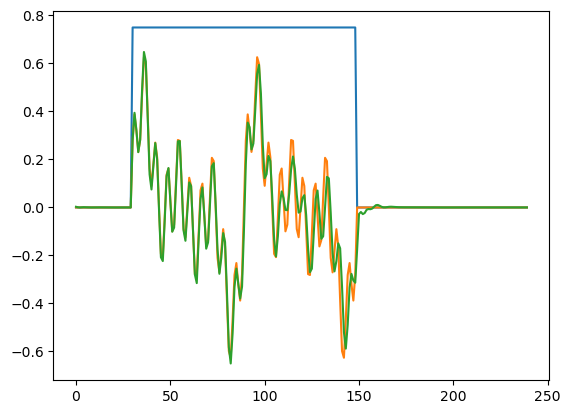

In [10]:
# Testing with a random input+target from dataloader

seq, target = next(iter(train_dataloader))
batch_size = target.shape[0] # batch size
random = np.random.randint(0,batch_size-2)

seq = seq[random,:].unsqueeze(0).unsqueeze(2).to(dev)
target = target[random,:].unsqueeze(0).unsqueeze(2).to(dev)

# Calculate Output
GRUnet.eval()
out = GRUnet(seq)

eval_loss =torch.sum(torch.abs(target-out))
print("[TEST ON STEP] Eval loss {}".format(eval_loss))

plt.plot(seq[0,:,:].detach().cpu().numpy())
plt.plot(target[0,:,:].detach().cpu().numpy())
plt.plot(out[0,:,:].detach().cpu().numpy())
plt.show()

## Testing with ramp input

/tmp/ipykernel_6086/380904300.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.harmonics = torch.tensor(harmonics)


[TEST 0 with RAMP] Eval loss 26.64323616027832


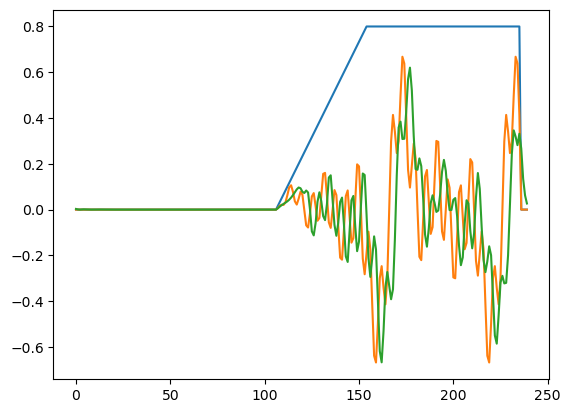

[TEST 1 with RAMP] Eval loss 34.467079162597656
[TEST 2 with RAMP] Eval loss 28.120174407958984
[TEST 3 with RAMP] Eval loss 23.56943130493164
[TEST 4 with RAMP] Eval loss 13.941239356994629
[TEST 5 with RAMP] Eval loss 15.320150375366211
[TEST 6 with RAMP] Eval loss 2.6205363273620605


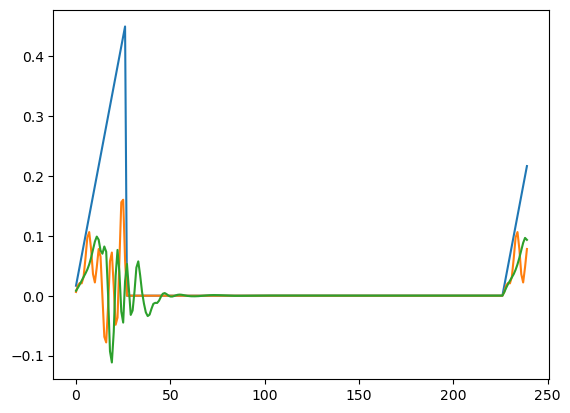

[TEST 7 with RAMP] Eval loss 22.372203826904297
[TEST 8 with RAMP] Eval loss 8.975431442260742
[TEST 9 with RAMP] Eval loss 18.027759552001953
[TEST 10 with RAMP] Eval loss 43.081661224365234


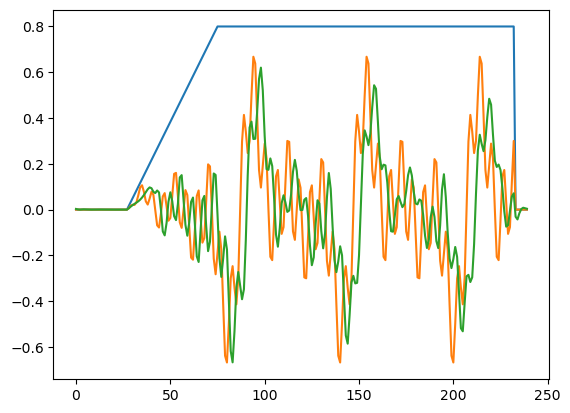

[TEST 11 with RAMP] Eval loss 26.466468811035156
[TEST 12 with RAMP] Eval loss 2.9553678035736084


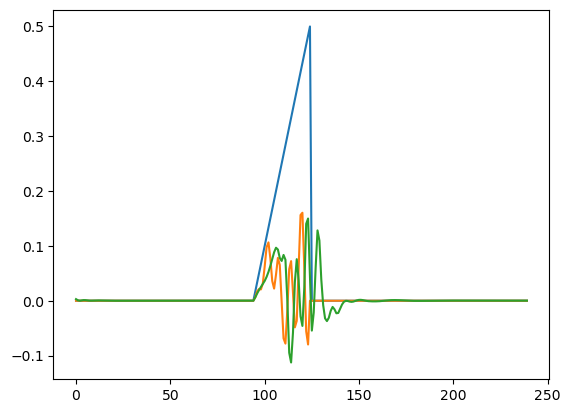

[TEST 13 with RAMP] Eval loss 4.442624092102051


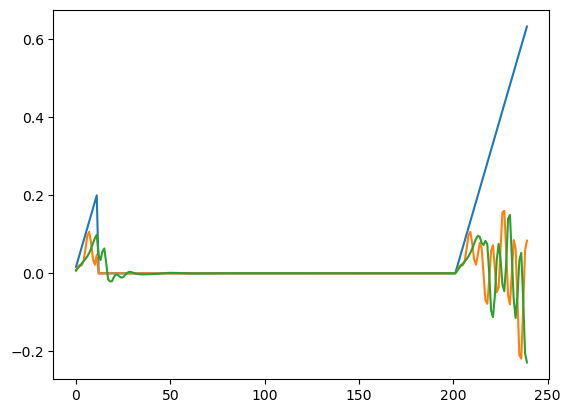

[TEST 14 with RAMP] Eval loss 28.74467658996582
[TEST 15 with RAMP] Eval loss 9.543383598327637
[TEST 16 with RAMP] Eval loss 21.231393814086914
[TEST 17 with RAMP] Eval loss 14.719813346862793
[TEST 18 with RAMP] Eval loss 21.426860809326172
[TEST 19 with RAMP] Eval loss 17.421714782714844
[TEST 20 with RAMP] Eval loss 34.48358154296875


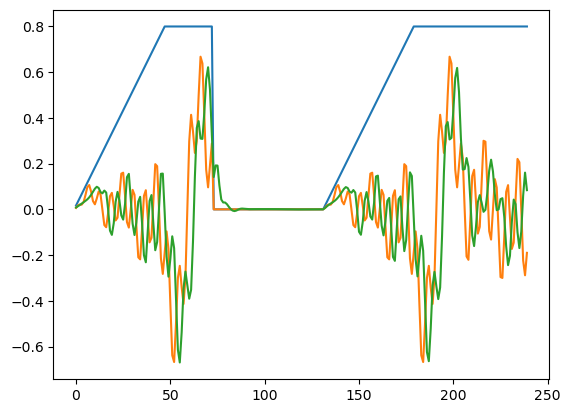

[TEST 21 with RAMP] Eval loss 11.382375717163086
[TEST 22 with RAMP] Eval loss 30.435791015625
[TEST 23 with RAMP] Eval loss 40.93618392944336
[TEST 24 with RAMP] Eval loss 1.091963768005371


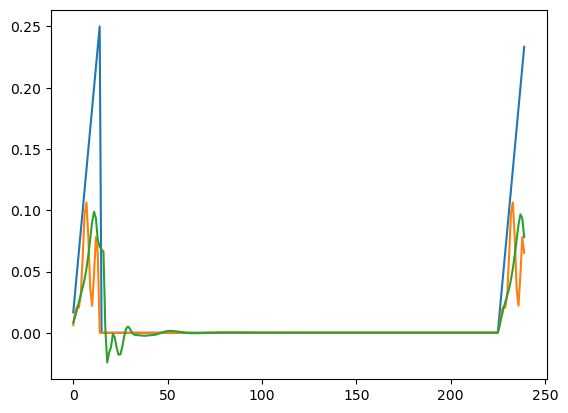

[TEST 25 with RAMP] Eval loss 18.948280334472656
[TEST 26 with RAMP] Eval loss 16.627239227294922
[TEST 27 with RAMP] Eval loss 33.35596466064453
[TEST 28 with RAMP] Eval loss 15.014923095703125
[TEST 29 with RAMP] Eval loss 16.440196990966797
[TEST 30 with RAMP] Eval loss 42.042476654052734


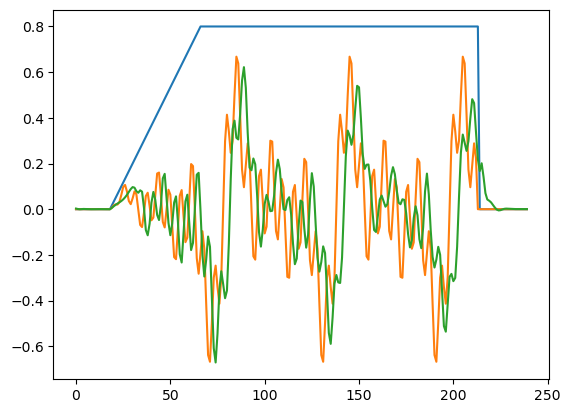

[TEST 31 with RAMP] Eval loss 14.148652076721191
[TEST 32 with RAMP] Eval loss 21.71306610107422
[TEST 33 with RAMP] Eval loss 21.477699279785156
[TEST 34 with RAMP] Eval loss 42.09320831298828
[TEST 35 with RAMP] Eval loss 18.754657745361328
[TEST 36 with RAMP] Eval loss 16.99280548095703
[TEST 37 with RAMP] Eval loss 38.74006271362305
[TEST 38 with RAMP] Eval loss 15.847419738769531
[TEST 39 with RAMP] Eval loss 37.168052673339844
[TEST 40 with RAMP] Eval loss 14.15046501159668


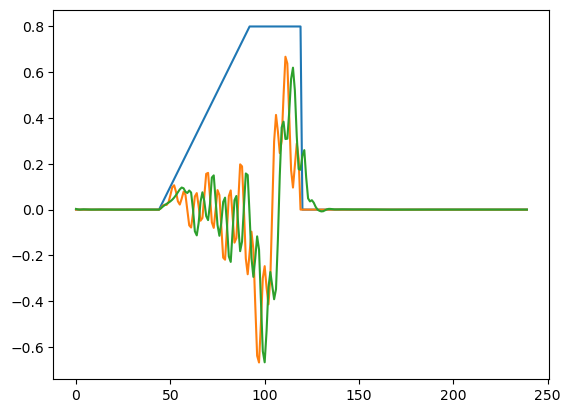

[TEST 41 with RAMP] Eval loss 36.29766845703125
[TEST 42 with RAMP] Eval loss 36.31755065917969
[TEST 43 with RAMP] Eval loss 25.554628372192383
[TEST 44 with RAMP] Eval loss 21.478666305541992
[TEST 45 with RAMP] Eval loss 21.429332733154297
[TEST 46 with RAMP] Eval loss 37.25202178955078
[TEST 47 with RAMP] Eval loss 2.8258838653564453


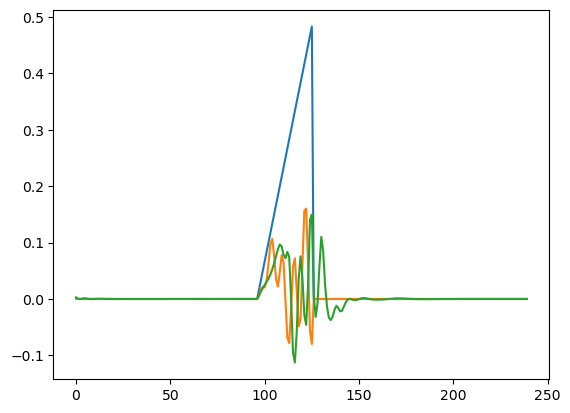

[TEST 48 with RAMP] Eval loss 4.488259792327881


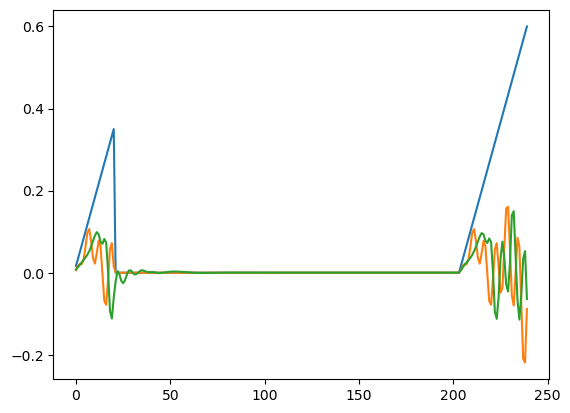

[TEST 49 with RAMP] Eval loss 16.37106704711914
[TEST 50 with RAMP] Eval loss 4.011853218078613


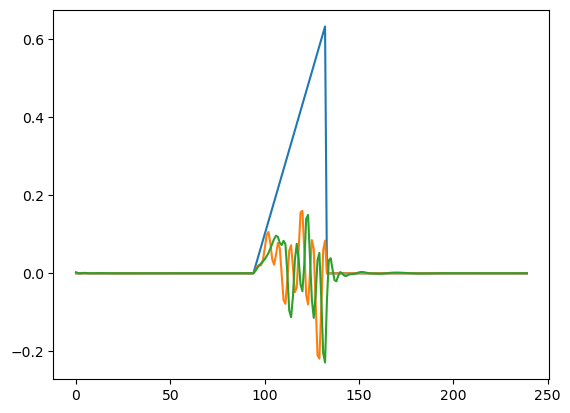

[TEST 51 with RAMP] Eval loss 21.422645568847656
[TEST 52 with RAMP] Eval loss 15.838067054748535
[TEST 53 with RAMP] Eval loss 10.577183723449707
[TEST 54 with RAMP] Eval loss 21.686254501342773
[TEST 55 with RAMP] Eval loss 11.163776397705078
[TEST 56 with RAMP] Eval loss 29.362953186035156
[TEST 57 with RAMP] Eval loss 19.654277801513672
[TEST 58 with RAMP] Eval loss 4.229251861572266


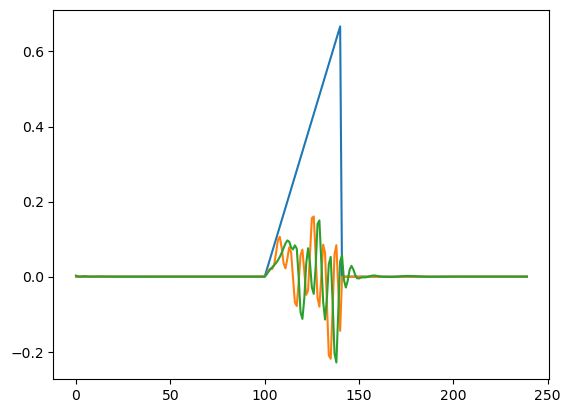

[TEST 59 with RAMP] Eval loss 16.991592407226562
[TEST 60 with RAMP] Eval loss 8.559172630310059


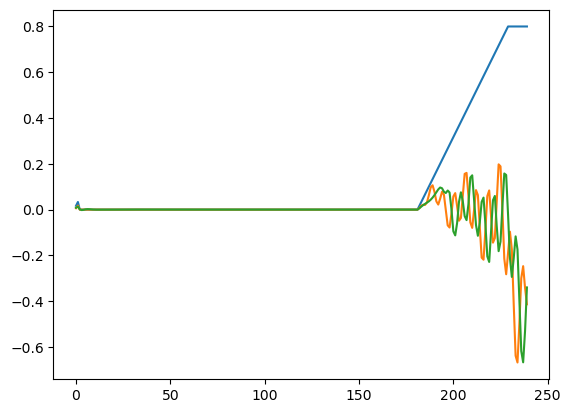

[TEST 61 with RAMP] Eval loss 19.90093994140625
[TEST 62 with RAMP] Eval loss 27.07921600341797
[TEST 63 with RAMP] Eval loss 28.334949493408203
[TEST 64 with RAMP] Eval loss 27.380451202392578
[TEST 65 with RAMP] Eval loss 5.392828941345215
[TEST 66 with RAMP] Eval loss 18.037113189697266
[TEST 67 with RAMP] Eval loss 26.658130645751953
[TEST 68 with RAMP] Eval loss 30.883121490478516
[TEST 69 with RAMP] Eval loss 34.988922119140625
[TEST 70 with RAMP] Eval loss 32.201725006103516


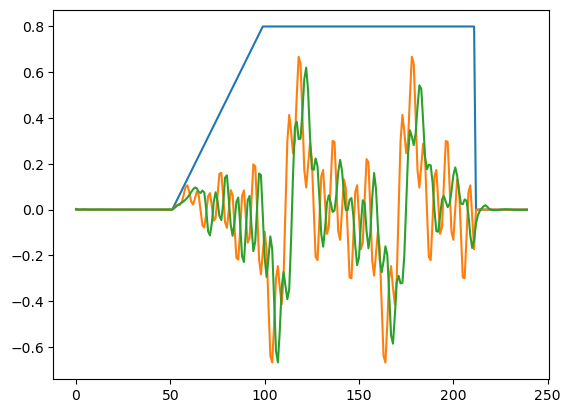

[TEST 71 with RAMP] Eval loss 31.290019989013672
[TEST 72 with RAMP] Eval loss 26.012304306030273
[TEST 73 with RAMP] Eval loss 38.56108474731445
[TEST 74 with RAMP] Eval loss 5.392755508422852
[TEST 75 with RAMP] Eval loss 22.09091567993164
[TEST 76 with RAMP] Eval loss 2.2958590984344482


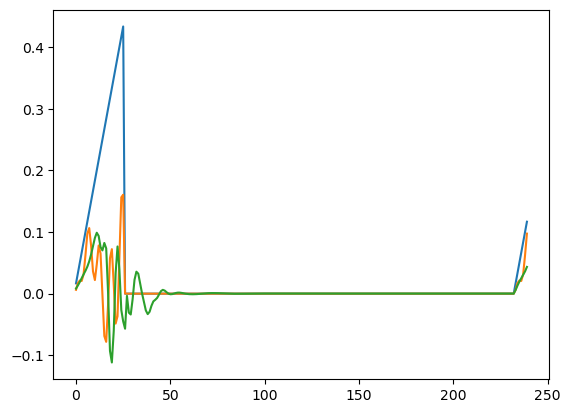

[TEST 77 with RAMP] Eval loss 28.275634765625
[TEST 78 with RAMP] Eval loss 32.07460021972656
[TEST 79 with RAMP] Eval loss 31.1440372467041
[TEST 80 with RAMP] Eval loss 17.37887954711914


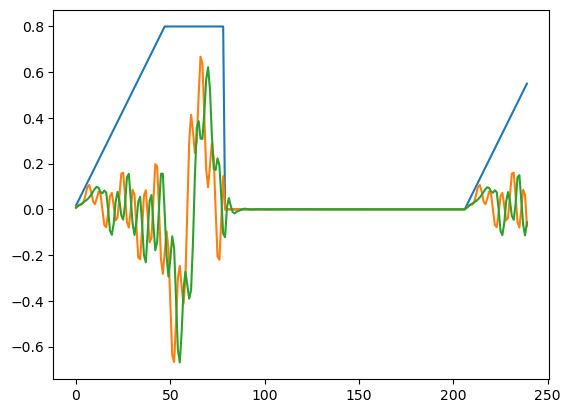

[TEST 81 with RAMP] Eval loss 18.01038360595703
[TEST 82 with RAMP] Eval loss 34.789825439453125
[TEST 83 with RAMP] Eval loss 18.61509895324707
[TEST 84 with RAMP] Eval loss 40.59954071044922
[TEST 85 with RAMP] Eval loss 0.7287945747375488


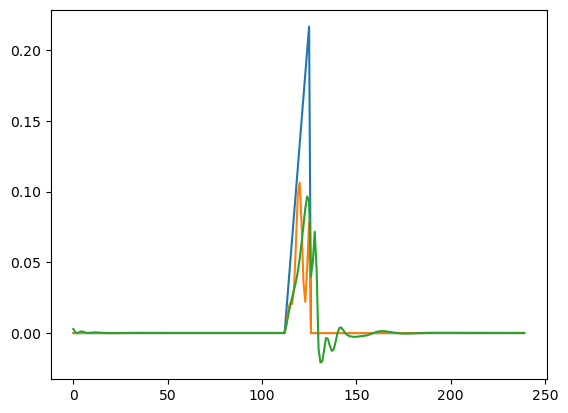

[TEST 86 with RAMP] Eval loss 20.185314178466797
[TEST 87 with RAMP] Eval loss 12.915140151977539
[TEST 88 with RAMP] Eval loss 17.358497619628906
[TEST 89 with RAMP] Eval loss 19.297277450561523
[TEST 90 with RAMP] Eval loss 6.9060959815979


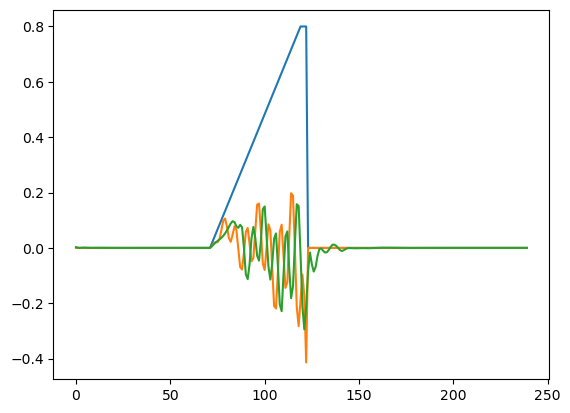

[TEST 91 with RAMP] Eval loss 20.874635696411133
[TEST 92 with RAMP] Eval loss 26.05553436279297
[TEST 93 with RAMP] Eval loss 35.75914764404297
[TEST 94 with RAMP] Eval loss 4.323415279388428


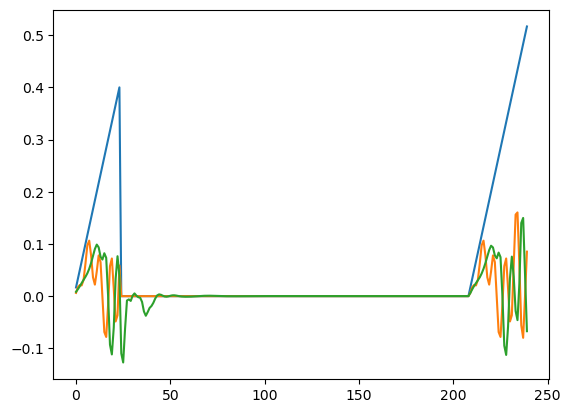

[TEST 95 with RAMP] Eval loss 12.3530912399292
[TEST 96 with RAMP] Eval loss 13.308966636657715
[TEST 97 with RAMP] Eval loss 4.011896133422852


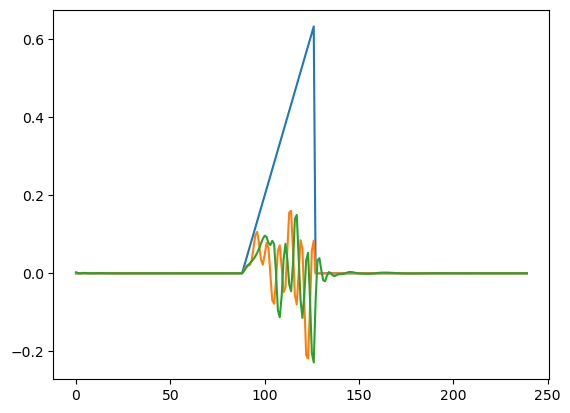

[TEST 98 with RAMP] Eval loss 40.713722229003906
[TEST 99 with RAMP] Eval loss 21.278221130371094


In [12]:
# Testing with a new dataset with amplitudes different from training dataset
# amplitudes = [float(input("Choose input amplitude for testing dataset: "))]
amplitudes = [0.8]
test_dataset = HarmonicSeriesDataset(harmonics=harmonics, shape='ramp', n_periods=n_periods, amplitudes=amplitudes)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

for i in range(100):
    seq, target = next(iter(test_dataloader))
    seq = seq[random,:].unsqueeze(0).unsqueeze(2).to(dev)
    target = target[random,:].unsqueeze(0).unsqueeze(2).to(dev)

    # Calculate Output
    out = GRUnet(seq)
    
    # Calculate Eval Loss
    eval_loss =torch.sum(torch.abs(target-out))
    print("[TEST {} with RAMP] Eval loss {}".format(i,eval_loss))
    
    if eval_loss <= 5.0:
        plt.plot(seq[0,:,:].detach().cpu().numpy())
        plt.plot(target[0,:,:].detach().cpu().numpy())
        plt.plot(out[0,:,:].detach().cpu().numpy())
        plt.show()    

    elif i%10==0:
        plt.plot(seq[0,:,:].detach().cpu().numpy())
        plt.plot(target[0,:,:].detach().cpu().numpy())
        plt.plot(out[0,:,:].detach().cpu().numpy())
        plt.show()